In [3]:
import Base.bp2DState
from Base.bp2DSimpleHeuristics import single_type_heuristic, first_fit, next_fit, most_enclosed_position, max_rest, \
    best_fit, first_fit_decreasing, next_fit_decreasing, get_all_heuristics, random_fit
from Base.bp2DState import State
from Base.bpReadWrite import ReadWrite
from Base.bp2DBox import Box
from Base.bpStateGenerators import random_state_generator, state_generator
import time

from Base.bp2DPlot import plot_packing_state
from Base.bp2DSimpleHeuristicsFunctions import most_enclosed_position_in_bin
from Base.bp2DState import Bin
from Base.bp2DState import Action, State
from Base.bpUtil import *
from Base.bpStateGenerators import random_state_generator
import matplotlib.pyplot as plt

## extreme data

In [61]:
count = 500
test_state = random_state_generator((10, 10),count // 2,1,3,1,3)
for box in random_state_generator((10, 10),count // 2,8,10,8,10).boxes_open:
    test_state.append_open_box(box)
path = f"test_instances/extremes_{count}"
    
ReadWrite.write_state(path=path, state=test_state)

### medium data

In [78]:
count = 5000
test_state = random_state_generator((10, 10),count,4,6,4,6)
path = f"test_instances/medium_{count}"
    
ReadWrite.write_state(path=path, state=test_state)

In [72]:
def ffd_fast(state: State, plot_result=False, plot_steps=False, plot_name=None):
    '''ffd'''
    start = time.time()
    step = 0
    name = 'ffd_plot'
    if plot_name is not None:
        name = plot_name
    sort_boxes_in_state(state)
    while state.has_open_boxes():
        box = state.get_next_open_box()
        first_fit(state, box)

        if plot_steps:
            plot_packing_state(state=state, step=step, fname=f"./vis/{name}_step")
            step += 1
    if plot_result:
        plot_packing_state(state, fname=f"./vis/{name}_result")
    state.solution_runtime = time.time() - start

In [73]:
def ffd_shaker(state: State, plot_result=False, plot_steps=False, plot_name=None, speed_mode = False):
    '''ffd shaker'''
    start = time.time()
    step = 0
    name = 'ffd_shaker_plot'
    if plot_name is not None:
        name = plot_name
    sort_boxes_in_state(state)
    fill_state = False
    last_bin = 0
    while state.has_open_boxes():
        box = state.get_next_open_box()
        
        if fill_state:
        # in this state we try to fit smallest containers in remaining space, without creating new bins
            placement_success = False
            for i in range(last_bin, len(state.bins)):
                placement_success = state.place_box_in_bin(box, i)
                if placement_success:
                    break

            if not placement_success:
                state.boxes_open = state.boxes_open[::-1]
                fill_state = False
                if speed_mode:
                    last_bin = len(state.bins) - 1
                    
        else:
         # in this state we create containers, until find the container, which fits into created bins 
            placement_success = False
            for i in range(last_bin, len(state.bins)):
                placement_success = state.check_if_fits_somewhere_in_box(box, i)
                if placement_success:
                    state.boxes_open = state.boxes_open[::-1]
                    fill_state = True
                    break

            if not placement_success:
                state.open_new_bin()
                state.place_box_in_bin_at_pnt(box, -1, Point(0, 0))
            

        if plot_steps:
            plot_packing_state(state=state, step=step, fname=f"./vis/{name}_step")
            step += 1
    if plot_result:
        plot_packing_state(state, fname=f"./vis/{name}_result")
    state.solution_runtime = time.time() - start

In [89]:
def ffd_shaker_pro(state: State, plot_result=False, plot_steps=False, plot_name=None, speed_mode = False):
    '''ffd shaker'''
    start = time.time()
    step = 0
    name = 'ffd_shaker_pro_plot'
    if plot_name is not None:
        name = plot_name
    # i tried both w and h in key, it doesn't work. Area is the best
    sort_boxes_in_state(state, keyfkt = lambda x: (x.a))
    fill_state = 0
    last_bin = 0
    while state.has_open_boxes():
        box = state.get_next_open_box()
        
        if fill_state == 2:
        # in this state we try to fit smallest containers in remaining space, without creating new bins
            placement_success = False
            for i in range(last_bin, len(state.bins)):
                placement_success = state.place_box_in_bin(box, i)
                if placement_success:
                    break

            if not placement_success:
                state.boxes_open = state.boxes_open[::-1]
                fill_state = False
                if speed_mode:
                    last_bin = len(state.bins) - 1
                    
        else:
         # in this state we create containers, until find the container, which fits into created bins 
            placement_success = False
            for i in range(last_bin, len(state.bins)):
                placement_success = state.place_box_in_bin(box, i)
                if placement_success:
                        fill_state = 1
                        break

            if not placement_success:
                if fill_state == 0:
                    state.open_new_bin()
                    state.place_box_in_bin_at_pnt(box, -1, Point(0, 0))
                elif fill_state == 1:
                    state.boxes_open = state.boxes_open[::-1]
                    fill_state = 2
            

        if plot_steps:
            plot_packing_state(state=state, step=step, fname=f"./vis/{name}_step")
            step += 1
    if plot_result:
        plot_packing_state(state, fname=f"./vis/{name}_result")
    state.solution_runtime = time.time() - start

### shaker pro - fitting while we can

1147


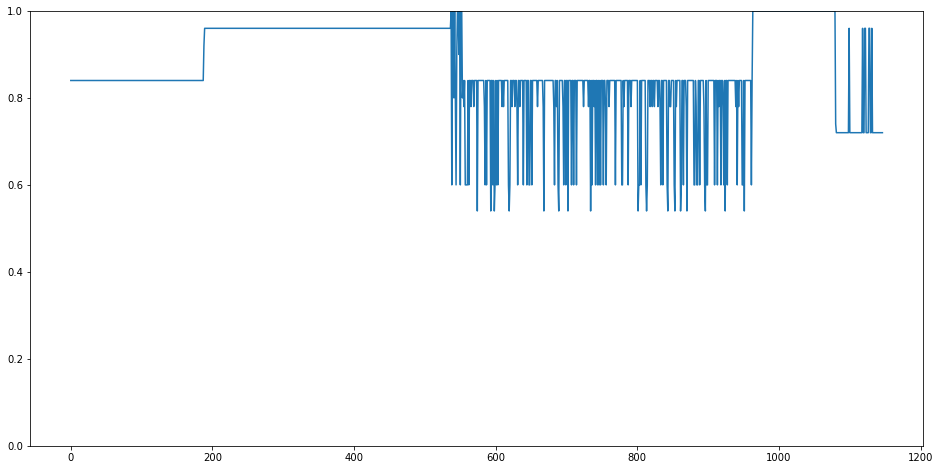

In [90]:
#1147 with area
solution_pro = ReadWrite.read_state(path)
ffd_shaker_pro(solution_pro , speed_mode = True)
#print(f"Is solution of {'shaker ffd'} valid? {solution.is_valid(init)}!")
print(f"{len(solution_pro.bins)}")

density_shaker_pro = []
solution = solution_pro
density = density_shaker_pro
for binn in solution.bins:
    density.append((100 - binn.capacity_available()) / 100)
#density = sorted(density, key = lambda x: -x)
plt.figure(figsize=(16,8))
plt.ylim(bottom=0)
plt.plot(density);

In [85]:
solution_pro.solution_runtime

278.437682390213

### good old shaker

1179


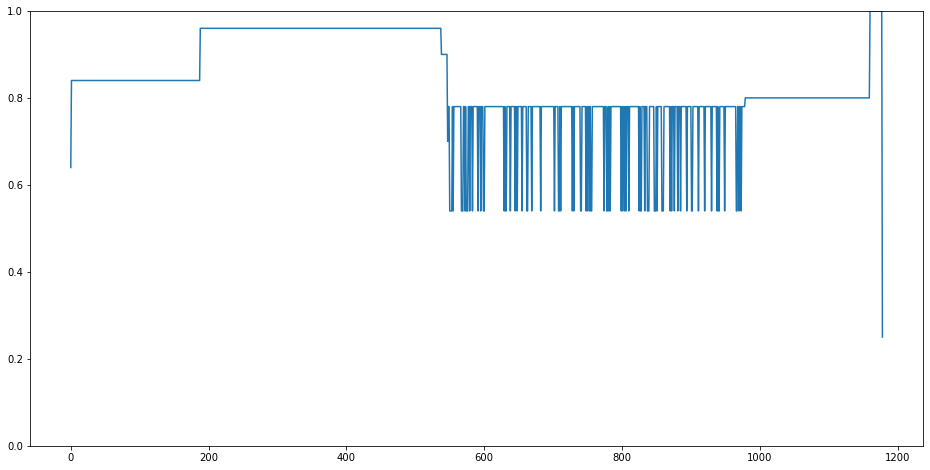

In [76]:
solution_shaker = ReadWrite.read_state(path)
ffd_shaker(solution_shaker, speed_mode = True)
#print(f"Is solution of {'shaker ffd'} valid? {solution.is_valid(init)}!")
print(f"{len(solution_shaker.bins)}")


density_shaker = []
solution = solution_shaker
density = density_shaker
for binn in solution.bins:
    density.append((100 - binn.capacity_available()) / 100)
#density = sorted(density, key = lambda x: -x)
plt.figure(figsize=(16,8))
plt.ylim(bottom=0)
plt.plot(density);

### default ffd

In [77]:
solution_ffd = ReadWrite.read_state(path)
ffd_fast(solution_ffd)
#print(f"Is solution of {'shaker ffd'} valid? {solution.is_valid(init)}!")
print(f"{len(solution_ffd.bins)}")

KeyboardInterrupt: 

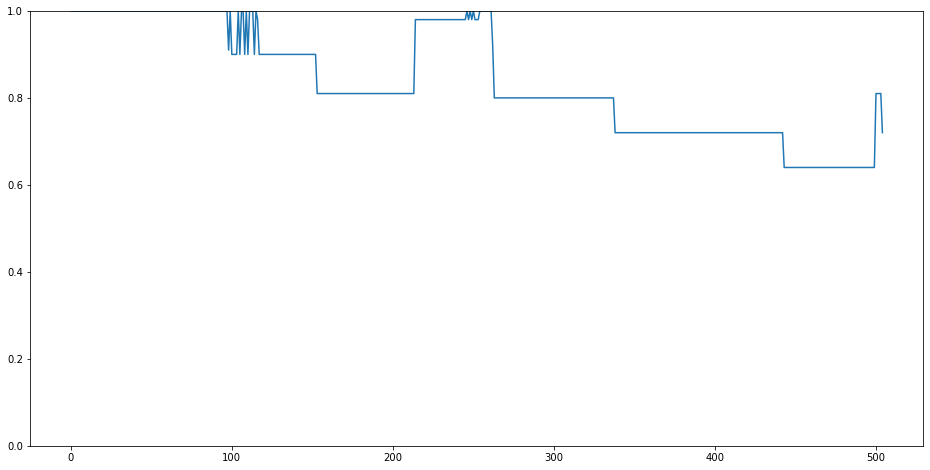

In [26]:
density_ffd = []
solution = solution_ffd
density = density_ffd
for binn in solution.bins:
    density.append((100 - binn.capacity_available()) / 100)
#density = sorted(density, key = lambda x: -x)
plt.figure(figsize=(16,8))
plt.ylim(bottom=0)
plt.plot(density);

In [28]:
len(density_shaker)

504